Projet Numéro 4 : Parser
-------------------

Sommaire :
1. [Processing](#Processing)
2. [Grammar_rules](#grammar_rules)
2. [NP_chunks](#np_chunks)

#### Processing

Nous allons commencer par écrire une fonction qui permet de traiter d'une phrase/texte.

In [1]:
import nltk
from glob import glob

In [2]:
%%writefile parser_package/utils/processing.py
from parser_package import *

def preprocess(sentence: str):
    """Convert `sentence` to a list of its words.
    Pre-process sentence by converting all characters to lowercase
    and removing any word that does not contain at least one alphabetic
    character.

    Args:
        sentence (str): Le texte à traiter
    """
    
    # the goal is to tokenize the given sentence and recuperate them if their are composed
    # by alphanumerical characters and if it is the case then transform to lower case
    tokens = [token.lower() for token in nltk.word_tokenize(sentence) if token.isalpha()]
    
    # return a list of tokens
    return tokens
    

Overwriting parser_package/utils/processing.py


Testons la fonction:

In [3]:
from parser_package.utils.processing import preprocess

tokens = preprocess("Je suis la")

In [4]:
tokens

['je', 'suis', 'la']

#### Grammar_rules

Les symboles terminaux ont déja été initialisés. Nous n'aurons donc qu'à créer les symboles non terminaux.

In [5]:
TERMINALS = """
Adj -> "country" | "dreadful" | "enigmatical" | "little" | "moist" | "red"
Adv -> "down" | "here" | "never"
Conj -> "and" | "until"
Det -> "a" | "an" | "his" | "my" | "the"
N -> "armchair" | "companion" | "day" | "door" | "hand" | "he" | "himself"
N -> "holmes" | "home" | "i" | "mess" | "paint" | "palm" | "pipe" | "she"
N -> "smile" | "thursday" | "walk" | "we" | "word"
P -> "at" | "before" | "in" | "of" | "on" | "to"
V -> "arrived" | "came" | "chuckled" | "had" | "lit" | "said" | "sat"
V -> "smiled" | "tell" | "were"
"""

NONTERMINALS = """
S -> NP | NP VP | S Conj S
PP -> P NP
NP -> N | Det N | Det Adj N | NP Adv | NP PP | NP Conj NP 
VP -> V | V V | VP Adv | VP NP | VP PP | VP Conj VP
Adj -> Adj Adj
"""

In [6]:
grammar = nltk.CFG.fromstring(NONTERMINALS + TERMINALS)
parser = nltk.ChartParser(grammar)

Chargeons les textes.

In [7]:
sentences = []

for file_ in glob("sentences/*.txt"):
    
    with open(file_, "r") as f:
    
        sentences.append(f.read().strip())        

In [8]:
len(sentences)

10

In [9]:
sentences

['I had a little moist red paint in the palm of my hand.',
 'I had a country walk on Thursday and came home in a dreadful mess.',
 'Holmes sat down and lit his pipe.',
 'My companion smiled an enigmatical smile.',
 'Holmes sat in the red armchair and he chuckled.',
 'Holmes chuckled to himself.',
 'She never said a word until we were at the door here.',
 'We arrived the day before Thursday.',
 'Holmes lit a pipe.',
 'Holmes sat.']

Créons une fonction qui nous permet de charger les arbres de jonctions grammaticales.

In [10]:
%%writefile parser_package/utils/get_trees.py
# import nltk
from typing import Union
from parser_package.utils.processing import preprocess

def get_trees(texts: Union[str, list], parser, to_list: bool = True):
    
    # get a list of sentences if texts is of type string
    if type(texts) is str: texts = [texts]
    
    # initialize trees
    trees = []
    
    # parse sentences
    for sentence in texts:
        
        # recuperate tokens
        tokens = preprocess(sentence)
        
        try:
            
            # parse the sentence
            tree = parser.parse(tokens)
            
            # convert the tree to a list if necessary
            if to_list: tree = list(tree)
            
            # add the new tree to the bunch of trees
            trees.append(tree)
            
        except Exception as e:
            
            # if the parsing don't work for that sentence then print a error
            print(f"Le parser n'arrive pas à analyser la phrase {sentence}")
            print(e)
    # return a list of trees
    return trees

Overwriting parser_package/utils/get_trees.py


In [11]:
from parser_package.utils.get_trees import get_trees

trees = get_trees(sentences, parser)

Let's recuperate the first tree for our next part

In [12]:
tree = trees[0]

#### NP_Chunks

Nous allons utiliser la recherche en profondeur pour trouver les sous arbres de symbole terminal $NP$.

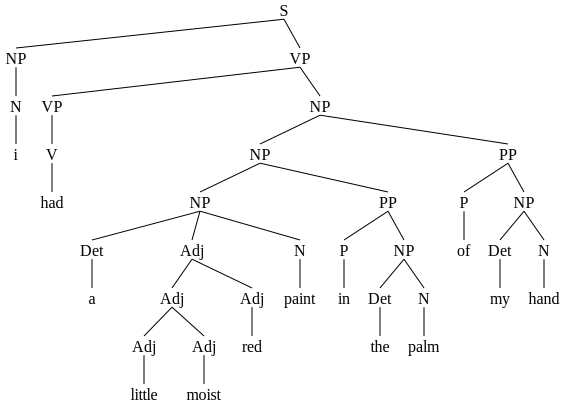

In [19]:
tree[0]

In [20]:
def contains_subtree(tree, label: str = 'NP', skip_first: bool = True):
    
    # get all subtrees of the given tree 
    for i, subtree in enumerate(list(tree.subtrees())): 
        
        # if we want only the descendent so we skip the first element
        if i == 0 and skip_first:
            
            continue
        
        # verify if a subtree is a noun phrase chunk
        if subtree.label() == 'NP':
            print(subtree.label())
            subtree.pretty_print()
            # return True if it is the case
            return True
    
    # return False if we didn't find a noun phrase subtree
    return False

The next code recuperates the np_chunks.

In [21]:
np_chunks = []
for tree_ in list(tree[0].subtrees()):
    
    # tree_.pretty_print()
    
    label = tree_.label()
    
    if label == 'NP':
        
        non_unique = contains_subtree(tree_, label)
        
        if not non_unique:
            
            np_chunks.append(tree_)
    

NP
                      NP                       
                  ____|_____________            
                 NP                 |          
  _______________|_________         |           
 |              Adj        |        PP         
 |           ____|____     |     ___|___        
 |         Adj        |    |    |       NP     
 |     _____|____     |    |    |    ___|___    
Det  Adj        Adj  Adj   N    P  Det      N  
 |    |          |    |    |    |   |       |   
 a  little     moist red paint  in the     palm

NP
                 NP           
  _______________|_________    
 |              Adj        |  
 |           ____|____     |   
 |         Adj        |    |  
 |     _____|____     |    |   
Det  Adj        Adj  Adj   N  
 |    |          |    |    |   
 a  little     moist red paint



In [22]:
np_chunks

[Tree('NP', [Tree('N', ['i'])]),
 Tree('NP', [Tree('Det', ['a']), Tree('Adj', [Tree('Adj', [Tree('Adj', ['little']), Tree('Adj', ['moist'])]), Tree('Adj', ['red'])]), Tree('N', ['paint'])]),
 Tree('NP', [Tree('Det', ['the']), Tree('N', ['palm'])]),
 Tree('NP', [Tree('Det', ['my']), Tree('N', ['hand'])])]

Make a test.

In [23]:
np_chunks = []
for tree_ in list(tree[0].subtrees()):
    
    # tree_.pretty_print()
    
    label = tree_.label()
    
    if label == 'NP':
        
        non_unique = contains_subtree(tree_, label)
        
        # if not non_unique:
            
        np_chunks.append(tree_)

NP
                      NP                       
                  ____|_____________            
                 NP                 |          
  _______________|_________         |           
 |              Adj        |        PP         
 |           ____|____     |     ___|___        
 |         Adj        |    |    |       NP     
 |     _____|____     |    |    |    ___|___    
Det  Adj        Adj  Adj   N    P  Det      N  
 |    |          |    |    |    |   |       |   
 a  little     moist red paint  in the     palm

NP
                 NP           
  _______________|_________    
 |              Adj        |  
 |           ____|____     |   
 |         Adj        |    |  
 |     _____|____     |    |   
Det  Adj        Adj  Adj   N  
 |    |          |    |    |   
 a  little     moist red paint



In [24]:
np_chunks

[Tree('NP', [Tree('N', ['i'])]),
 Tree('NP', [Tree('NP', [Tree('NP', [Tree('Det', ['a']), Tree('Adj', [Tree('Adj', [Tree('Adj', ['little']), Tree('Adj', ['moist'])]), Tree('Adj', ['red'])]), Tree('N', ['paint'])]), Tree('PP', [Tree('P', ['in']), Tree('NP', [Tree('Det', ['the']), Tree('N', ['palm'])])])]), Tree('PP', [Tree('P', ['of']), Tree('NP', [Tree('Det', ['my']), Tree('N', ['hand'])])])]),
 Tree('NP', [Tree('NP', [Tree('Det', ['a']), Tree('Adj', [Tree('Adj', [Tree('Adj', ['little']), Tree('Adj', ['moist'])]), Tree('Adj', ['red'])]), Tree('N', ['paint'])]), Tree('PP', [Tree('P', ['in']), Tree('NP', [Tree('Det', ['the']), Tree('N', ['palm'])])])]),
 Tree('NP', [Tree('Det', ['a']), Tree('Adj', [Tree('Adj', [Tree('Adj', ['little']), Tree('Adj', ['moist'])]), Tree('Adj', ['red'])]), Tree('N', ['paint'])]),
 Tree('NP', [Tree('Det', ['the']), Tree('N', ['palm'])]),
 Tree('NP', [Tree('Det', ['my']), Tree('N', ['hand'])])]

In [25]:
np_1 = np_chunks[0]

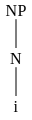

In [26]:
np_1

In [27]:
contains_subtree(np_1, 'NP')

False

In [28]:
np_2 = np_chunks[1]

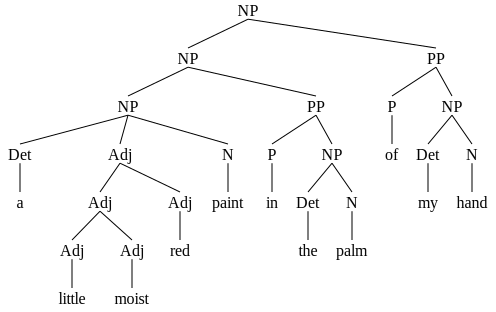

In [29]:
np_2

In [30]:
contains_subtree(np_2)

NP
                      NP                       
                  ____|_____________            
                 NP                 |          
  _______________|_________         |           
 |              Adj        |        PP         
 |           ____|____     |     ___|___        
 |         Adj        |    |    |       NP     
 |     _____|____     |    |    |    ___|___    
Det  Adj        Adj  Adj   N    P  Det      N  
 |    |          |    |    |    |   |       |   
 a  little     moist red paint  in the     palm



True

Mettons les traitements précédents dans une fonction.

In [31]:
%%writefile parser_package/utils/np_chunks.py

def contains_subtree(tree, label: str = 'NP', skip_first: bool = True):
    """Verify if a tree contains a subtree

    Args:
        tree (Tree): A tree from a parsed sentence
        label (str, optional): The label of the chunk that we search for. Defaults to 'NP'.
        skip_first (bool, optional): Skip the parent. Defaults to True.

    Returns:
        bool: True if the tree contains the subtree (for which we predefined the label), False else
    """
    
    # get all subtrees of the given tree 
    for i, subtree in enumerate(list(tree.subtrees())): 
        
        # if we want only the descendent so we skip the first element
        if i == 0 and skip_first:
            
            continue
        
        # verify if a subtree is a noun phrase chunk
        if subtree.label() == label:
            
            # return True if it is the case
            return True
    
    # return False if we didn't find a noun phrase subtree
    return False

def get_chunks(tree, label_: str = 'NP'):
    
    # initialize the list of chunks
    chunks = []
    
    for tree_ in list(tree.subtrees()):
        
        # recuperate the label
        label = tree_.label()
        
        # if it is the searched label then
        if label == label_:
            
            # verify if the subtree contains subtrees with the same label
            non_unique = contains_subtree(tree_, label)
            
            # it it is not the case then add a new chunk to the bunch of chunks
            if not non_unique:
                
                chunks.append(tree_)
    
    # return the bunch of chunks
    return chunks


Overwriting parser_package/utils/np_chunks.py


Let's make a test for each tree.

In [32]:
from parser_package.utils.np_chunks import get_chunks

np_chunks = []

for tree_ in trees:
    
    np_chunks.append(get_chunks(tree_[0]))

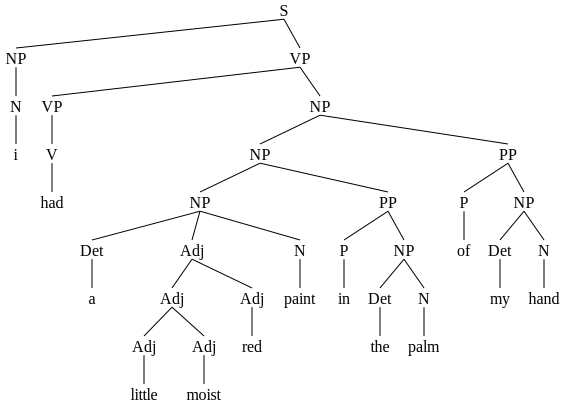

In [44]:
trees[0][0]

In [33]:
np_chunks[0]

[Tree('NP', [Tree('N', ['i'])]),
 Tree('NP', [Tree('Det', ['a']), Tree('Adj', [Tree('Adj', [Tree('Adj', ['little']), Tree('Adj', ['moist'])]), Tree('Adj', ['red'])]), Tree('N', ['paint'])]),
 Tree('NP', [Tree('Det', ['the']), Tree('N', ['palm'])]),
 Tree('NP', [Tree('Det', ['my']), Tree('N', ['hand'])])]

In [34]:
np_chunks[1]

[Tree('NP', [Tree('N', ['i'])]),
 Tree('NP', [Tree('Det', ['a']), Tree('Adj', ['country']), Tree('N', ['walk'])]),
 Tree('NP', [Tree('N', ['thursday'])]),
 Tree('NP', [Tree('N', ['home'])]),
 Tree('NP', [Tree('Det', ['a']), Tree('Adj', ['dreadful']), Tree('N', ['mess'])])]

In [35]:
np_chunks[2]

[Tree('NP', [Tree('N', ['holmes'])]),
 Tree('NP', [Tree('Det', ['his']), Tree('N', ['pipe'])])]

In [36]:
np_chunks[3]

[Tree('NP', [Tree('Det', ['my']), Tree('N', ['companion'])]),
 Tree('NP', [Tree('Det', ['an']), Tree('Adj', ['enigmatical']), Tree('N', ['smile'])])]

In [37]:
np_chunks[4]

[Tree('NP', [Tree('N', ['holmes'])]),
 Tree('NP', [Tree('Det', ['the']), Tree('Adj', ['red']), Tree('N', ['armchair'])]),
 Tree('NP', [Tree('N', ['he'])])]

In [38]:
np_chunks[5]

[Tree('NP', [Tree('N', ['holmes'])]), Tree('NP', [Tree('N', ['himself'])])]

In [39]:
np_chunks[6]

[Tree('NP', [Tree('N', ['she'])]),
 Tree('NP', [Tree('Det', ['a']), Tree('N', ['word'])]),
 Tree('NP', [Tree('N', ['we'])]),
 Tree('NP', [Tree('Det', ['the']), Tree('N', ['door'])])]

In [40]:
np_chunks[7]

[Tree('NP', [Tree('N', ['we'])]),
 Tree('NP', [Tree('Det', ['the']), Tree('N', ['day'])]),
 Tree('NP', [Tree('N', ['thursday'])])]

In [41]:
np_chunks[8]

[Tree('NP', [Tree('N', ['holmes'])]),
 Tree('NP', [Tree('Det', ['a']), Tree('N', ['pipe'])])]

In [42]:
np_chunks[9]

[Tree('NP', [Tree('N', ['holmes'])])]